In [ ]:
#| hide
#| default_exp optimize
from nbdev import *

# Sampling optimizer

> The post-processing procedure to fit the sampling set to the target distribution. This code is an implementation of the clever idea by Janek Łażewski to replace crude weighting produced by the Metropolis-Hastings algorithm by weights derived directly from the PDF of the target distribution. This idea makes the acceptance ratio essentially 100% and allows nice tricks like changing of the target distribution (e.g. shifting of the target temperature of the sample or even scanning of the temperature range using prior distribution generated using `plan_T_scan`).

In [ ]:
#| hide
#| exporti
from scipy import stats
from matplotlib import pylab as plt
import ase.units as un
import numpy as np
import itertools 

In [ ]:
#| exporti
flatten = itertools.chain.from_iterable

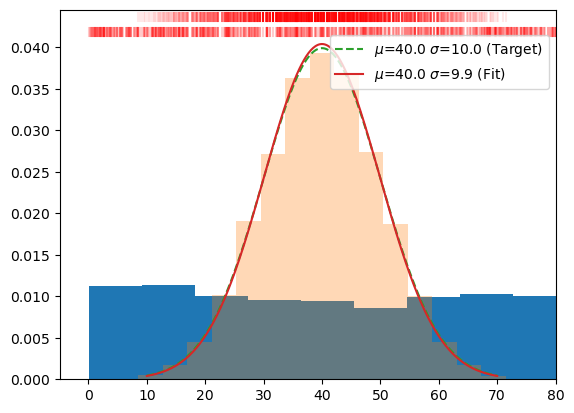

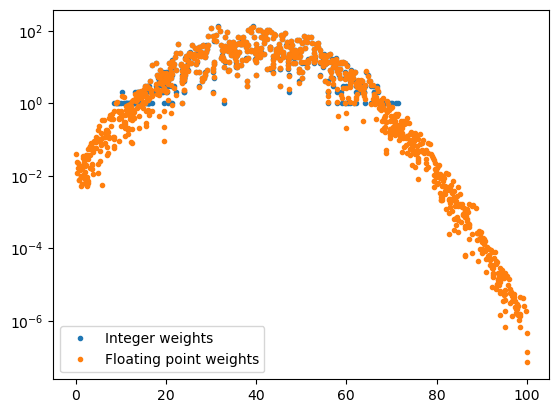

In [ ]:
#| hide
def refit(data, mu, sigma, sigma_scale=1.0, probTH=0.25, N=None, Nb=None, target=stats.norm):
    '''
    Re-shaper of the data distribution
    '''
    # Data multiplication factor
    if N is None:
        N = 10*len(data)
    
    # Target distribution
    # You can use slightly (5% for N=10*len(data)) smaller sigma 
    # to compensate for the missing tails below weight=1
    g = target(mu, sigma_scale*sigma)
    d = np.sort(data)
    
    # Make bins for PDF evaluation
    # Each data point gets its own bin by splitting 
    # the distance between data points in half.
    # The boundary points get symmetrical bins.
    bb = np.zeros(len(d)+1)
    bb[1:-1] = (d[:-1]+d[1:])/2
    bb[0] = d[0]-(d[1]-d[0])/2
    bb[-1] = d[-1]+(d[-1]-d[-2])/2
    # bin widths
    bw = bb[1:]-bb[:-1]

    cdf = g.cdf(bb)
    w = cdf[1:]-cdf[:-1]

    # Data weights to fit the target distribution
    # w = g.pdf(bp)*bw
    w /= w.sum()
    nf = N
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    # iw = np.round(w*nf) + (1*(np.abs(d - mu) < 3*sigma))
    iw = nf*w
    # Don't remove low probability data, rise weights above probTH
    # This will deform (rise) the wings of the histogram
    iw[np.logical_and(probTH<iw, iw<1)]=1
    iw = np.round(iw)

    # Weight the data by multiplication of data points
    wd = list(flatten([int(ww)*[dd] for ww, dd in zip(iw,d) if ww>=1]))

    if Nb is None :
        Nb = min(len(data)//4, 15)
        
    h, b, _ = plt.hist(wd, bins=Nb, density=True, alpha=0.3);
    x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
    fit = target.fit(wd)
    plt.plot( x, target.pdf(x, mu, sigma), '--', label=f'$\mu$={mu:.1f} $\sigma$={sigma:.1f} (Target)' )
    plt.plot( x, target.pdf(x, *fit), label=f'$\mu$={fit[0]:.1f} $\sigma$={fit[1]:.1f} (Fit)' )
    skip = len(d)//2000
    skip = int(max(1, skip))
    nf = (iw[::skip]).max()
    for s, a in zip(d[::skip], iw[::skip]):
        if a<1e-3:
            continue
        plt.axvline(s, ymin=0.97, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
    
    return w, iw, wd

N = 1_000
d = np.sort(stats.uniform.rvs(0, 100, size=N))
plt.hist(d, bins='auto', density=True);
skip = len(d)//2000
skip = int(max(1, skip))
for s in d[::skip]:
    plt.axvline(s, ymin=0.93, ymax=0.95, ls='-', color='r', alpha=0.2)              
m = 40
s = 10
fw, iw, wd = refit(d, m, s, probTH=0.5, N=10*len(d))
plt.xlim(None, m+4*s)
plt.ylim(None, 1.05*plt.ylim()[1])
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));

plt.show()
plt.semilogy()
plt.plot(d[iw>0], iw[iw>0], '.', label='Integer weights')
plt.plot(d, len(wd)*fw, '.', label='Floating point weights')
plt.legend();

In [ ]:
#| asap

from hecss.monitor import plot_stats, plot_virial_stat, plot_xs_stat
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat
from hecss.util import select_asap_model, create_asap_calculator
from hecss import HECSS
from ase.build import bulk
from ase.spacegroup import crystal

In [ ]:
#| asap

model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '1x1x1'
sys_size = '2x2x2'
sys_size = '3x3x3'
sys_size = '4x4x4'
sys_size = '5x5x5'
sc = [int(v) for v in sys_size.split('x')]
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(create_asap_calculator(model))

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


  0%|          | 0/10 [00:00<?, ?it/s]

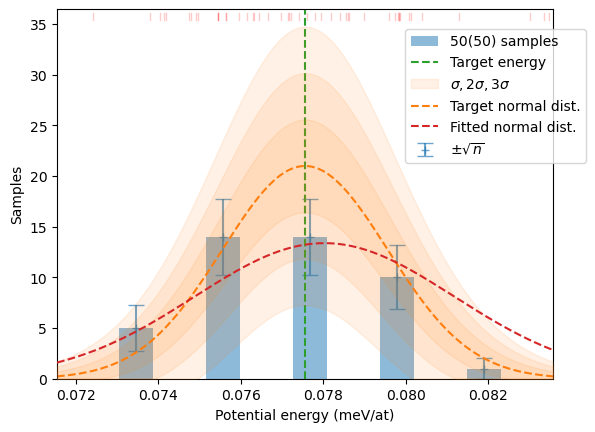

In [ ]:
#| asap

T = 600
N = 50
hecss = HECSS(cryst, lambda : create_asap_calculator(model), pbar=True)
hecss.estimate_width_scale(10, Tmax=1000)
smpls = [s for s in hecss._sampler(T, N)]
plot_stats(smpls, T, sqrN=True, show=False)
plt.savefig('AUX/hecss_prior.pdf', bbox_inches='tight')

In [ ]:
#| export
def get_sample_weights(data, T, sigma_scale=1.0, debug=False):
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    # Use slightly (10%) wider sigma to compensate 
    # for the missing tails below weight=1
    g = stats.norm(mu, sigma_scale*sigma)
    e = np.fromiter((s[-1] for s in data), float)
    idx = np.argsort(e)
    ridx = np.arange(len(idx))[idx]
    d = e[idx]
    if debug:
        N_bins = min(len(data)//4, 15)
        mh = plt.hist(d, bins=N_bins, density=True, alpha=0.3, label='Raw data')[0].max()
        plt.plot(d, -0.05*mh*np.ones(d.shape), '|', alpha=max(0.01, min(1.0, 100/len(d))))
        plt.axhline(lw=1, ls=':')
        
    bb = np.zeros(len(d)+1)
    bb[1:-1] = (d[:-1]+d[1:])/2
    bb[0] = d[0]-(d[1]-d[0])/2
    bb[-1] = d[-1]+(d[-1]-d[-2])/2
    # bin widths
    bw = bb[1:]-bb[:-1]

    cdf = g.cdf(bb)
    w = cdf[1:]-cdf[:-1]
    w /= w.sum()
    if debug:
        plt.stairs(w/bw, bb, fill=False, lw=1, label='Float weighted samples')
        x = np.linspace(e.min(), e.max(), 100)
        plt.plot(x, g.pdf(x), '-', label='Target')
        plt.hist(d, weights=w, bins=N_bins, density=True, alpha=0.3, label='Weighted data (without nonzero_w)')
        plt.xlim(mu-5*sigma, mu+5*sigma)
        plt.legend(loc='upper left', bbox_to_anchor=(0.6, 0.95))
        plt.show()

    return w, idx

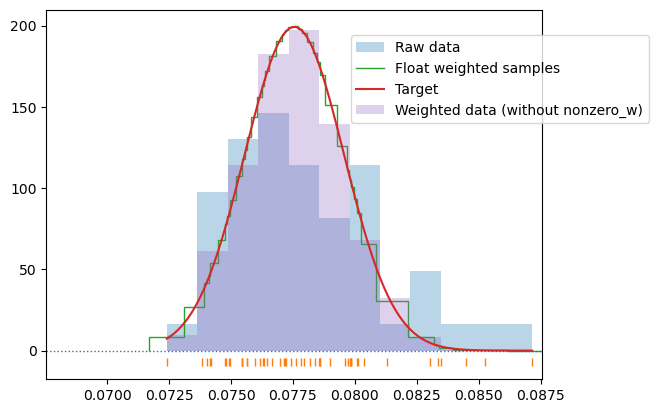

In [ ]:
#| asap

wgh, idx =  get_sample_weights(smpls, T, debug=True)

In [ ]:
#| export
def make_sampling(data, T, sigma_scale=1.0, probTH=0.25, Nmul=4, N=None, 
                  nonzero_w=True, debug=False, N_bins=None):
    if N is None:
        N = int(Nmul*len(data))
    if Nmul>25 :
        print('Warning: You cannot generate data from thin air. Nmul above 25 is pointless. Doing it anyway.')
    if N_bins is None :
        N_bins = min(len(data)//4, 15)
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    w, idx = get_sample_weights(data, T, sigma_scale=sigma_scale, debug=debug)
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    # iw = np.round(w*nf) + (1*(np.abs(d - mu) < 3*sigma))
    iw = N*w
    if nonzero_w:
        # Don't remove low probability data, rise weights above probTH
        # This will deform (rise) the wings of the histogram
        iw[np.logical_and(probTH<iw, iw<1)]=1
    iw = np.round(iw)

    # Weight the data by multiplication of data points
    wd = []
    iwnorm = iw.sum()
    for ww, ii in zip(iw,idx):
        if ww<1:
            continue
        wd += int(ww)*[data[ii]]
    # print(len(wd), wde.shape)
    # assert len(wd) == N
    if debug:
        wde = np.fromiter((s[-1] for s in wd), float)
        h, b, _ = plt.hist(wde, bins=N_bins, density=True, alpha=0.3);
        x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
        fit = stats.norm.fit(wde)
        plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', 
                 label=f'$\mu$={2*mu/3/un.kB:.1f}; $\sigma$={2*sigma/3/un.kB:.1f} (Target)' )
        plt.plot( x, stats.norm.pdf(x, *fit), 
                 label=f'$\mu$={2*fit[0]/3/un.kB:.1f}; $\sigma$={2*fit[1]/3/un.kB:.1f} (Fit)' )
        plt.title('Generated weighted sample')
        skip = len(data)//2000
        skip = int(max(1, skip))
        print(skip)
        nf = (w[::skip]).max()
        for s, a in zip(data[::skip], w[::skip]):
            if a<1e-3:
                continue
            plt.axvline(s[-1], ymin=0.95, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
        plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));
    return wd

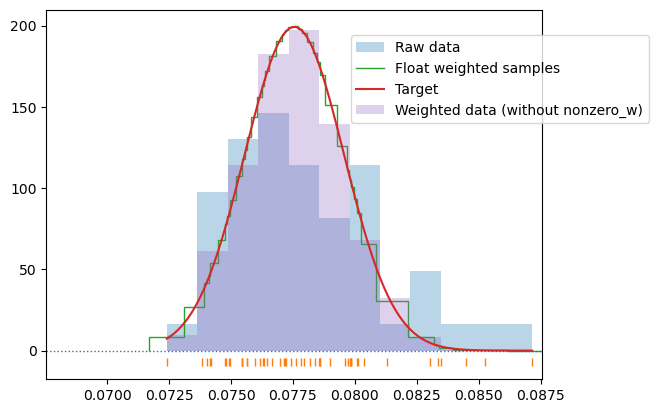

1


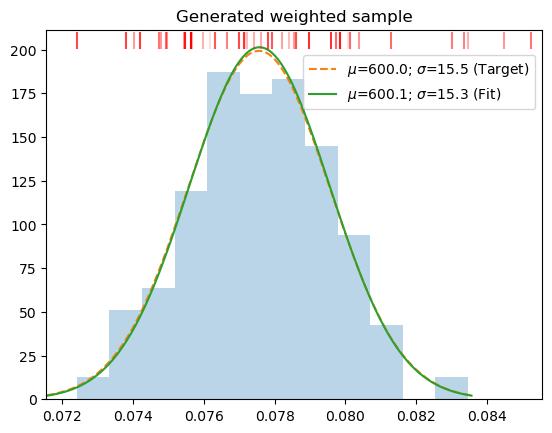

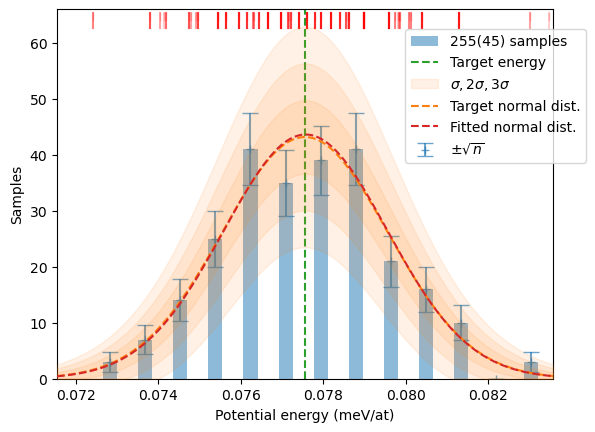

In [ ]:
#| asap

wd = make_sampling(smpls, T, probTH=0.25, debug=True, Nmul=5, nonzero_w=True)
plt.show()
plot_stats(wd, T, sqrN=True, show=False)
skip = max(1, len(wd)//2000)
alpha = min(1,50*skip/len(wd))
for s in wd[::skip]:
    plt.axvline(s[-1], ymin=0.95, ymax=0.99, ls='-', color='r', alpha=alpha)
plt.savefig('AUX/hecss_post.pdf', bbox_inches='tight')

In [ ]:
#| asap

uni = {}
N = 100
for T in 275, 300, 325:
    # uni[T]=[s for s in hecss._sampler(T, N)]
    uni[T] = hecss.sample(T, N)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#| asap

e_dist = {t:np.array([s[-1] for s in d]) for t, d in uni.items()}
e_uni = np.concatenate(tuple(e_dist.values()))
usmp = []
for s in uni.values():
    usmp += s

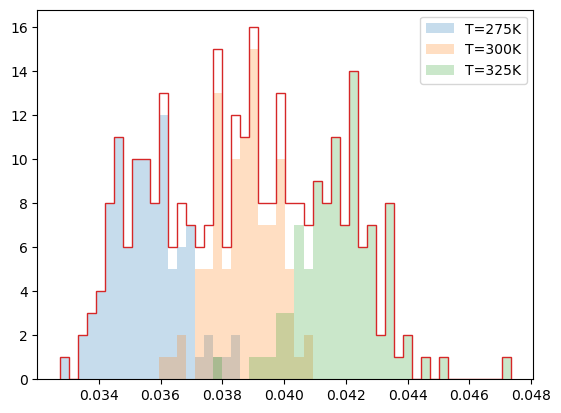

In [ ]:
#| asap

for T, ed in e_dist.items():
    plt.hist(ed, bins=50, label=f'{T=}K', alpha=0.25, range=(e_uni.min(), e_uni.max()))
plt.hist(e_uni, bins=50, histtype='step', stacked=True, range=(e_uni.min(), e_uni.max()))
plt.legend();

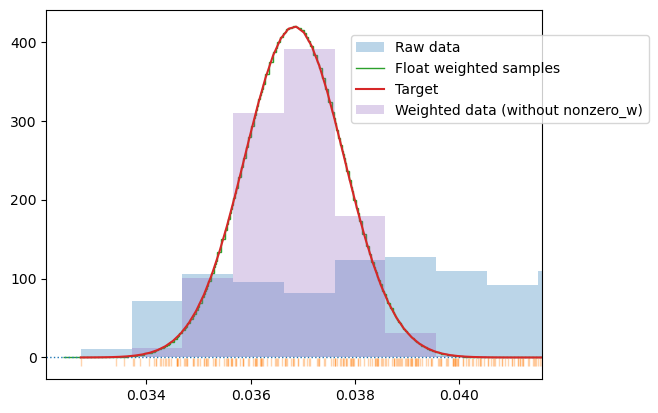

1
300 1500


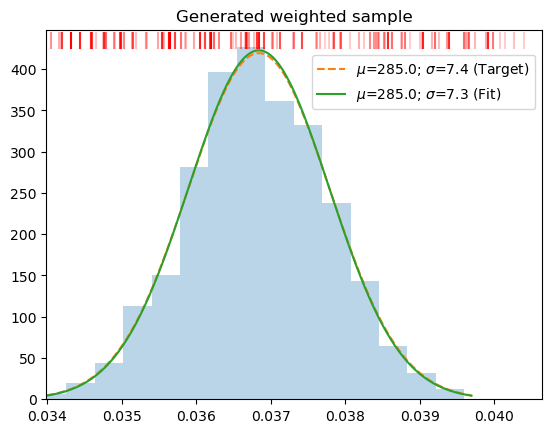

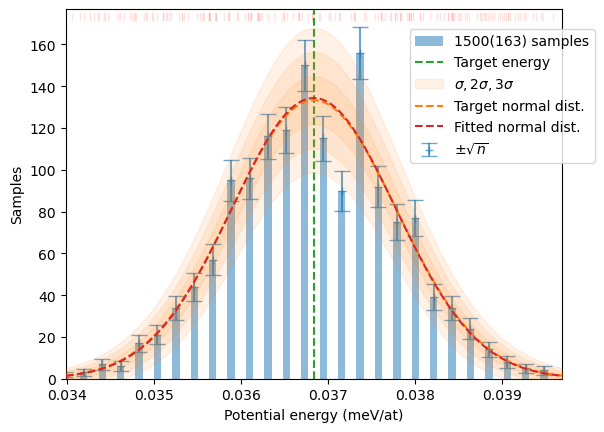

In [ ]:
#| asap

T = 285
wd = make_sampling(usmp, T, nonzero_w=False, debug=True, Nmul=5)
print(len(usmp), len(wd))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))
plt.show();
plot_stats(wd, T, sqrN=True, show=False)
plt.savefig(f'AUX/T_fit_{T=:.0f}K.pdf', bbox_inches='tight')